# O PROBLEMA

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados do IBOVESPA (Bolsa de Valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso, utilize a base de dados contida no site da investing e selecione o período 'diário', com intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

1. O modelo com storytelling, desde a captura do dado até a entrega do modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acurácia adequada (acima de 70%).

Dica: utilize o maior intervalo de tempo possível para atingir maior acurácia no modelo preditivo.

Fonte: https://br.investing.com/indices/bovespa-historical-data

## Importando bibliotecas

In [860]:
import warnings 
warnings.filterwarnings(action = 'ignore')

In [861]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

## Importando dados

In [862]:
df = pd.read_csv('Dados Históricos - Ibovespa.csv')

In [863]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5000 non-null   object 
 1   Último    5000 non-null   float64
 2   Abertura  5000 non-null   float64
 3   Máxima    5000 non-null   float64
 4   Mínima    5000 non-null   float64
 5   Vol.      4999 non-null   object 
 6   Var%      5000 non-null   object 
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


In [864]:
df.head()

Data   Último  Abertura   Máxima   Mínima    Vol.    Var%
0  09.03.2023  105.071   106.540  106.724  105.053  19,17M  -1,38%
1  08.03.2023  106.540   104.228  106.721  104.228  15,90M   2,22%
2  07.03.2023  104.228   104.700  105.179  103.480  12,58M  -0,45%
3  06.03.2023  104.700   103.865  105.171  103.170  14,28M   0,80%
4  03.03.2023  103.866   103.326  104.440  103.323  13,10M   0,52%

## Tratamento de dados

In [865]:
#verificando ocorrência de dados nulos
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [866]:
df[df['Vol.'].isnull()]

Data  Último  Abertura  Máxima  Mínima Vol.    Var%
1756  10.02.2016  40.377    40.592  40.592   39.96  NaN  -0,53%

In [867]:
df.drop(1860, inplace = True)
df.isna().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [868]:
#verificando valores duplicados
df.duplicated().sum()

0

In [869]:
#verificando ocorrência de espaçamentos
espacamento_encontrado = False

for column in df.columns:
    for index, value in df[column].items():
        if isinstance(value, str) and value.isspace():
            print(f'Espaçamento encontrado na coluna "{column}", linha {index}.')
            espacamento_encontrado = True

if not espacamento_encontrado:
    print('Não há espaçamento nos dados.')

Não há espaçamento nos dados.


In [870]:
#renomeando colunas
df.rename(columns = {
    'Data': 'data', 
    'Último': 'fechamento', 
    'Abertura': 'abertura', 
    'Máxima': 'maxima', 
    'Mínima': 'minima', 
    'Vol.': 'volume', 
    'Var%': 
    'variacao'}, inplace = True)
df.columns

Index(['data', 'fechamento', 'abertura', 'maxima', 'minima', 'volume',
       'variacao'],
      dtype='object')

In [871]:
#alterando tipo da coluna de data
df['data'] = df['data'].str.replace('.', '-')
df['data'] = pd.to_datetime(df['data'], format='%d-%m-%Y')

In [872]:
#alterando tipo da coluna de variação
df['variacao'] = df['variacao'].str.replace(',', '.')
df['variacao'] = df['variacao'].str.replace('%', '').astype(float)

In [873]:
df.head()

data  fechamento  abertura   maxima   minima  volume  variacao
0 2023-03-09     105.071   106.540  106.724  105.053  19,17M     -1.38
1 2023-03-08     106.540   104.228  106.721  104.228  15,90M      2.22
2 2023-03-07     104.228   104.700  105.179  103.480  12,58M     -0.45
3 2023-03-06     104.700   103.865  105.171  103.170  14,28M      0.80
4 2023-03-03     103.866   103.326  104.440  103.323  13,10M      0.52

In [874]:
#alterando tipo da coluna de volume
df['volume'] = df['volume'].str.replace(',', '.')
lista = []
for i, j in enumerate(df['volume']):
    if 'M' in str(df['volume'].iloc[i]):
        df['volume'].iloc[i] = df['volume'].iloc[i].replace('M', '')
        lista.append(round(float(df['volume'].iloc[i]) * 1000000))

    elif 'K' in str(df['volume'].iloc[i]):
        df['volume'].iloc[i] = df['volume'].iloc[i].replace('K', '')
        lista.append(round(float(df['volume'].iloc[i]) * 1000))
    else:
        lista.append(df['volume'].iloc[i])

In [875]:
df['volume'].shape

(4999,)

In [876]:
df['volume'] = lista

In [877]:
df.head()

data  fechamento  abertura   maxima   minima      volume  variacao
0 2023-03-09     105.071   106.540  106.724  105.053  19170000.0     -1.38
1 2023-03-08     106.540   104.228  106.721  104.228  15900000.0      2.22
2 2023-03-07     104.228   104.700  105.179  103.480  12580000.0     -0.45
3 2023-03-06     104.700   103.865  105.171  103.170  14280000.0      0.80
4 2023-03-03     103.866   103.326  104.440  103.323  13100000.0      0.52

In [878]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        4999 non-null   datetime64[ns]
 1   fechamento  4999 non-null   float64       
 2   abertura    4999 non-null   float64       
 3   maxima      4999 non-null   float64       
 4   minima      4999 non-null   float64       
 5   volume      4998 non-null   float64       
 6   variacao    4999 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 312.4 KB


In [879]:
df.set_index('data', inplace = True)
df.sort_index(inplace = True)
df.head()

fechamento  abertura  maxima  minima       volume  variacao
data                                                                   
2003-01-02      11.603    11.291  11.603  11.291  195130000.0      2.97
2003-01-03      11.600    11.632  11.798  11.600  197050000.0     -0.02
2003-01-06      12.020    11.636  12.032  11.633  398400000.0      3.62
2003-01-07      11.876    12.010  12.018  11.842  387980000.0     -1.19
2003-01-08      11.786    11.875  11.928  11.757  217190000.0     -0.76

In [880]:
df.describe()

fechamento     abertura       maxima       minima        volume  \
count  4999.000000  4999.000000  4999.000000  4999.000000  4.998000e+03   
mean     62.256559    62.238726    62.874926    61.605226  4.960862e+07   
std      28.202934    28.205272    28.422833    27.974319  1.029253e+08   
min       9.995000    10.006000    10.151000     9.968000  1.121000e+05   
25%      45.480000    45.469000    45.972000    44.994500  2.830000e+06   
50%      58.083000    58.076000    58.634000    57.534000  4.480000e+06   
75%      76.042000    76.021500    76.698000    75.307500  1.473750e+07   
max     130.776000   130.776000   131.190000   129.526000  9.949600e+08   

          variacao  
count  4999.000000  
mean      0.059088  
std       1.720100  
min     -14.780000  
25%      -0.850000  
50%       0.090000  
75%       1.010000  
max      14.660000

## EDA

### Distribuição das variáveis

In [881]:
fig = px.histogram(df, x = 'fechamento', nbins = 20, width = 800, height = 600)

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Histograma do Fechamento',
    xaxis_title = 'Fechamento',
    yaxis_title = 'Frequência'
)

fig.show()

In [882]:
fig = px.histogram(df, x = 'abertura', nbins = 20, width = 800, height = 600)

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Histograma da Abertura',
    xaxis_title = 'Abertura',
    yaxis_title = 'Frequência'
)

fig.show()

In [883]:
fig = px.box(df, x = 'volume', width = 800, height = 600)

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Boxplot do Volume',
    xaxis_title = 'Valor (R$)',
    yaxis_title = 'Volume'
)

fig.show()

In [884]:
fig = px.histogram(df, x = 'variacao', nbins = 20, width = 800, height = 600)

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Histograma da Variação',
    xaxis_title = 'Variação',
    yaxis_title = 'Frequência'
)

fig.show()

### Decompondo a série

Uma série temporal é dita estacionária se suas propriedades (média, variância, etc.) não dependem do tempo da observação. Portanto, séries que apresentam tendência ou sazonalidade não são estacionárias. Por outro lado, uma série composta por valores gerados aleatoriamente são estacionárias, visto que a “aparência” da série é basicamente a mesma para qualquer período t

In [885]:
from statsmodels.tsa.seasonal import seasonal_decompose #lib para decompor série temporal
from statsmodels.tsa.stattools import acf, pacf #autocorrelação e autocorrelação parcial

In [886]:
df_fechamento = df['fechamento'].to_frame()

In [887]:
resultados = seasonal_decompose(df_fechamento, period = 7)

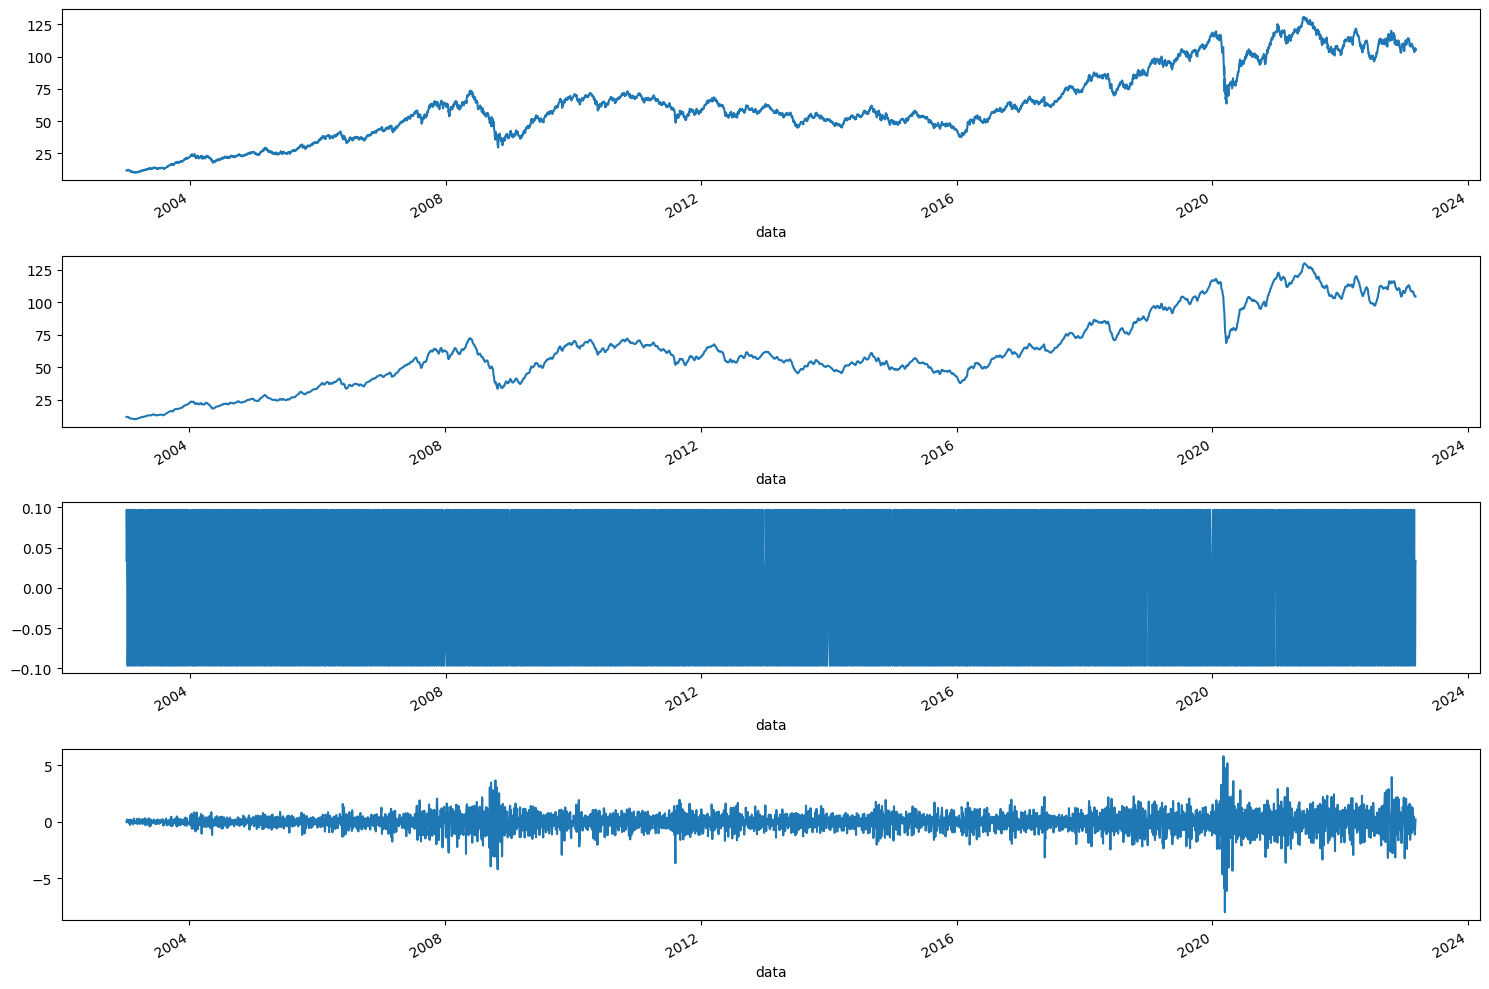

In [888]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15, 10))
resultados.observed.plot(ax = ax1)
resultados.trend.plot(ax = ax2)
resultados.seasonal.plot(ax = ax3)
resultados.resid.plot(ax = ax4)
plt.tight_layout()

In [889]:
ma_semanal

Média móvel semanal
data                           
2003-01-02                  NaN
2003-01-03                  NaN
2003-01-06                  NaN
2003-01-07                  NaN
2003-01-08              11.7770
...                         ...
2023-03-03             104.4440
2023-03-06             104.2418
2023-03-07             104.1010
2023-03-08             104.5320
2023-03-09             104.8810

[4999 rows x 1 columns]

In [890]:
ma_semanal = df_fechamento.rolling(5).mean().rename(columns = {'fechamento': 'Média móvel semanal'})
ma_anual = df_fechamento.rolling(52).mean()

fig = px.line(ma_semanal, width = 800, height = 600)
fig.add_scatter(x = ma_anual.index, y = ma_anual.fechamento, name = 'Média móvel anual')

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento',
    legend_title = 'Legenda'
)

fig.show()

In [891]:
df_log = np.log(df_fechamento).rename(columns = {'fechamento': 'Fechamento'})
ma_log = df_log.rolling(52).mean()

fig = px.line(df_log, width = 800, height = 600)
fig.add_scatter(x = ma_log.index, y = ma_log.Fechamento, name = 'Média móvel anual')

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento',
    legend_title = 'Legenda',
)

fig.show()

In [892]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


df_log = np.log(df_fechamento)
ma_log = df_log.rolling(12).mean()

df_s = (df_log - ma_log).dropna()
ma_s = df_s.rolling(12).mean()
std_s = df_s.rolling(12).std()

'''f, ax = plt.subplots(figsize = (8, 5))
df_s.plot(ax = ax, legend = False)
ma_s.plot(ax = ax, legend = False, color = 'r')
std_s.plot(ax = ax, legend = False, color = 'g')
plt.tight_layout()'''

fig = make_subplots(rows = 1, cols = 3, subplot_titles = ('Plot 1', 'Plot 1', 'Plot 1'))

fig.add_trace(go.Scatter(x = df_s.index, y = df_s.fechamento), row = 1, col = 1)
fig.add_trace(go.Scatter(x = ma_s.index, y = ma_s.fechamento), row = 1, col = 2)
fig.add_trace(go.Scatter(x = std_s.index, y = std_s.fechamento), row = 1, col = 3)


fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento'
)

fig.show()

In [893]:
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

'''f, ax = plt.subplots(figsize = (8, 5))
df_diff.plot(ax = ax, legend = False)
ma_diff.plot(ax = ax, legend = False, color = 'r')
std_diff.plot(ax = ax, legend = False, color = 'g')
plt.tight_layout()'''

from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = make_subplots(rows = 1, cols = 3)

fig.add_trace(go.Scatter(x = df_diff.index, y = df_diff.fechamento), row = 1, col = 1)
fig.add_trace(go.Scatter(x = ma_diff.index, y = ma_diff.fechamento), row = 1, col = 2)
fig.add_trace(go.Scatter(x = std_diff.index, y = std_diff.fechamento), row = 1, col = 3)


fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento'
)

fig.show()

## Teste estatístico de estacionariedade para a variável target

Uma série temporal é dita estacionária se suas propriedades (média, variância, etc.) não dependem do tempo da observação. Portanto, séries que apresentam tendência ou sazonalidade não são estacionárias. Por outro lado, uma série composta por valores gerados aleatoriamente são estacionárias, visto que a “aparência” da série é basicamente a mesma para qualquer período t.

### ADF - Augmented Dickey-Fuller

>H0 - Hipótese Nula (não é estacionária)

>H1 - Hipótese Alternativa (rejeita a hipótese nula)

**p-valor <= 0.05 rejeitamos H0 com um nível de confiança de 95%**

In [894]:
from statsmodels.tsa.stattools import adfuller


X = df.fechamento.values

result = adfuller(X)

print('Teste ADF')
print(f'Teste estatístico: {result[0]}')
print(f'P-valor: {result[1]}')
print(f'Valores críticos:')

for key, value in result[4].items():
    print(f'\t{key}: {value}')

Teste ADF
Teste estatístico: -1.5838547106943999
P-valor: 0.49169855973573384
Valores críticos:
	1%: -3.431661944885779
	5%: -2.8621197374408225
	10%: -2.5670785949998973


### ARIMA - AR (autoregressivo) I (integrado) MA (média móvel)

#### A (x, y, z) -> ACF, PACF

In [895]:
lag_acf = acf(df_diff.dropna(), nlags = 25) #trabalhando na base mensal
lag_pacf = pacf(df_diff.dropna(), nlags = 25)

### 5% ACF

##### 1.96 / sqrt(N - d) -> N (número de pontos da base), d (número de vezes que diferenciamos a base)

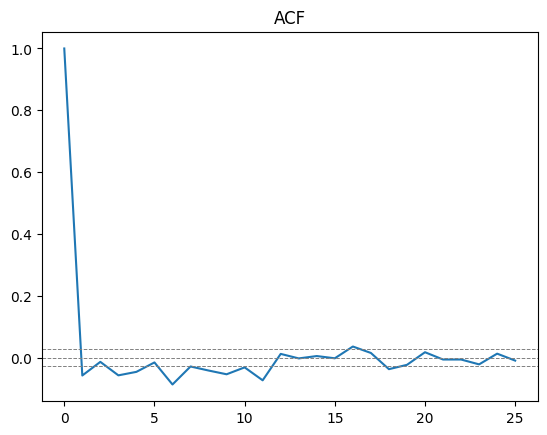

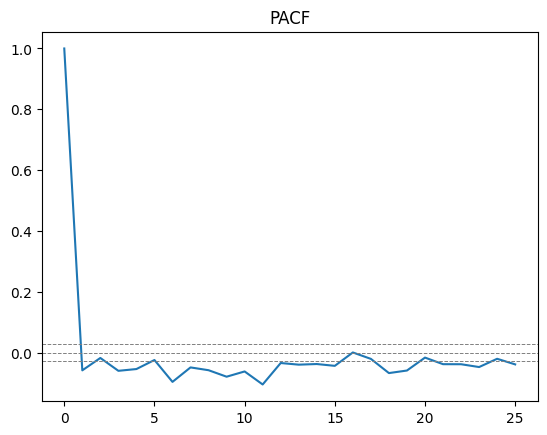

In [896]:
plt.plot(lag_acf)
plt.axhline(y = -1.96 / (np.sqrt(len(df_diff) -1)), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 0, linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 1.96 / (np.sqrt(len(df_diff) -1)), linestyle = '--', color = 'gray', linewidth = 0.7)

plt.title('ACF')
plt.show()

plt.plot(lag_pacf)
plt.axhline(y = -1.96 / (np.sqrt(len(df_diff) - 1)), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 0, linestyle = '--', color = 'gray', linewidth = 0.7)
plt.axhline(y = 1.96 / (np.sqrt(len(df_diff) - 1)), linestyle = '--', color = 'gray', linewidth = 0.7)

plt.title('PACF')
plt.show()

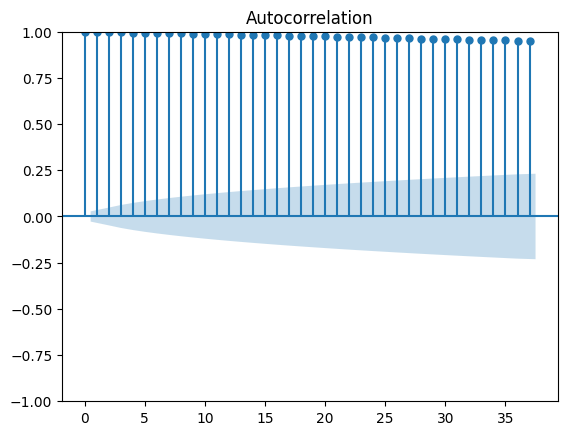

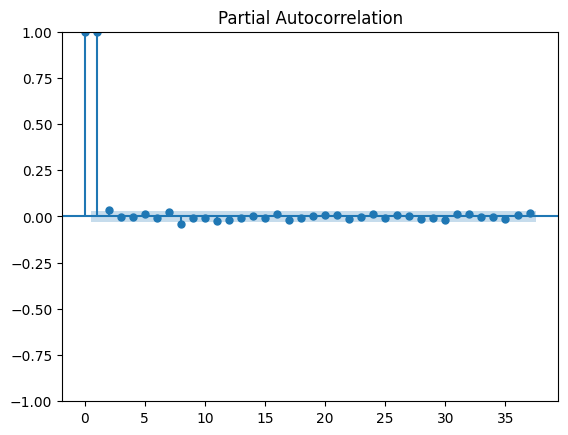

In [897]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df.fechamento)
plot_pacf(df.fechamento)
plt.show()

## Modelando

In [898]:
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [899]:
df_diff.reset_index(inplace = True)
df_diff = df_diff[['data', 'fechamento']].rename(columns = {'data': 'ds', 'fechamento': 'y'})
df_diff['unique_id'] = 'Fechamento'
df_diff.dropna(inplace = True)
df_diff.head()

ds         y   unique_id
1 2003-01-20 -0.002724  Fechamento
2 2003-01-21 -0.017262  Fechamento
3 2003-01-22 -0.019636  Fechamento
4 2003-01-23  0.006960  Fechamento
5 2003-01-24 -0.027048  Fechamento

In [900]:
df_diff.shape

(4987, 3)

In [901]:
df.reset_index(inplace = True)
df = df[['data', 'fechamento']].rename(columns = {'data': 'ds', 'fechamento': 'y'})
df['unique_id'] = 'Fechamento'
df.dropna(inplace = True)
df.head()

ds       y   unique_id
0 2003-01-02  11.603  Fechamento
1 2003-01-03  11.600  Fechamento
2 2003-01-06  12.020  Fechamento
3 2003-01-07  11.876  Fechamento
4 2003-01-08  11.786  Fechamento

In [902]:
df.shape

(4999, 3)

### Modelo baseline

In [903]:
from statsforecast import StatsForecast
from statsforecast.models import Naive

In [904]:
treino_diff = df_diff.loc[(df_diff['ds'] >= '2013-01-01') & (df_diff['ds'] < '2023-01-01')] #dados de treino
valid_diff = df_diff.loc[(df_diff['ds'] >= '2023-01-01') & (df_diff['ds'] < '2023-03-09')] #dados de validação (3 meses), quanto maior o período de predição, maior a largura de banda (maior o erro)
h = valid_diff['ds'].nunique() #datas distintas no intervalo (90 dias)
h

46

In [905]:
treino = df.loc[(df['ds'] >= '2013-01-01') & (df['ds'] < '2023-01-01')] #dados de treino
valid = df.loc[(df['ds'] >= '2023-01-01') & (df['ds'] < '2023-03-09')] #dados de validação (3 meses), quanto maior o período de predição, maior a largura de banda (maior o erro)
h = valid['ds'].nunique() #datas distintas no intervalo (90 dias)
h

46

In [906]:
'''t1 = df.loc[(df['ds'] >= '2003-01-01') & (df['ds'] < '2009-01-01')] 
t2 = df.loc[(df['ds'] >= '2009-01-01') & (df['ds'] < '2015-01-01')]
t3 = df.loc[(df['ds'] >= '2015-01-01') & (df['ds'] < '2019-01-01')]
treino_teste = pd.concat([t1, t2], ignore_index = True)
treino_teste = pd.concat([treino_teste, t3], ignore_index = True)
valid_teste = df.loc[(df['ds'] >= '2019-01-01') & (df['ds'] < '2019-04-01')] #dados de validação (3 meses), quanto maior o período de predição, maior a largura de banda (maior o erro)
h = valid_teste['ds'].nunique() #datas distintas no intervalo (90 dias)
h'''

"t1 = df.loc[(df['ds'] >= '2003-01-01') & (df['ds'] < '2009-01-01')] \nt2 = df.loc[(df['ds'] >= '2009-01-01') & (df['ds'] < '2015-01-01')]\nt3 = df.loc[(df['ds'] >= '2015-01-01') & (df['ds'] < '2019-01-01')]\ntreino_teste = pd.concat([t1, t2], ignore_index = True)\ntreino_teste = pd.concat([treino_teste, t3], ignore_index = True)\nvalid_teste = df.loc[(df['ds'] >= '2019-01-01') & (df['ds'] < '2019-04-01')] #dados de validação (3 meses), quanto maior o período de predição, maior a largura de banda (maior o erro)\nh = valid_teste['ds'].nunique() #datas distintas no intervalo (90 dias)\nh"

In [907]:
valid_diff.shape, treino_diff.shape

((46, 3), (2475, 3))

In [908]:
valid.shape, treino.shape

((46, 3), (2475, 3))

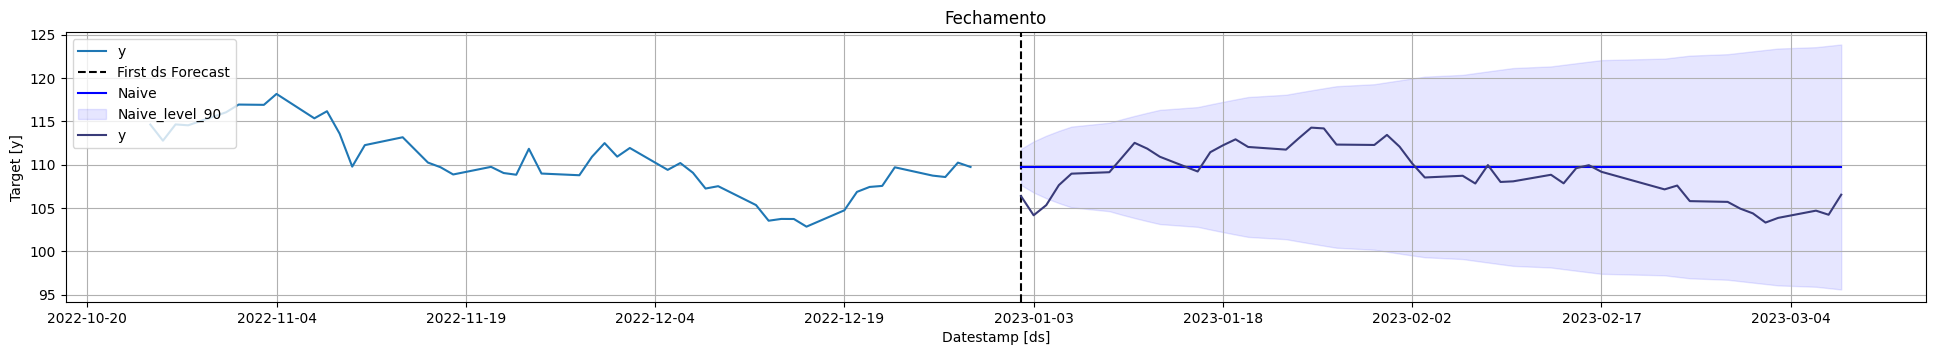

In [909]:
model = StatsForecast(
    models = [Naive()], 
    freq = 'D', 
    n_jobs = -1
) #n_jobs, quantidade de CPUs da máquina que será ultilizada

model.fit(treino)
forecast_df = model.predict(h = h, level = [90]) #level é a banda de confiança estabelecida
forecast_df.ds = valid.ds.to_list()
forecast_df = forecast_df.reset_index().merge(valid, on = ['ds', 'unique_id'], how = 'left')
model.plot(treino, forecast_df, level = [90], engine = 'matplotlib', max_insample_length = 46)

In [910]:
forecast_df.head()

unique_id         ds       Naive  Naive-lo-90  Naive-hi-90        y
0  Fechamento 2023-01-02  109.735001   107.653030   111.816971  106.376
1  Fechamento 2023-01-03  109.735001   106.790657   112.679344  104.166
2  Fechamento 2023-01-04  109.735001   106.128929   113.341072  105.334
3  Fechamento 2023-01-05  109.735001   105.571068   113.898933  107.641
4  Fechamento 2023-01-06  109.735001   105.079582   114.390419  108.964

In [911]:
forecast_df.shape

(46, 6)

In [912]:
wmape_baseline = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f'WMAPE: {wmape_baseline:.2%}')

WMAPE: 2.40%


### Modelo baseline com sazonalidade

In [913]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive

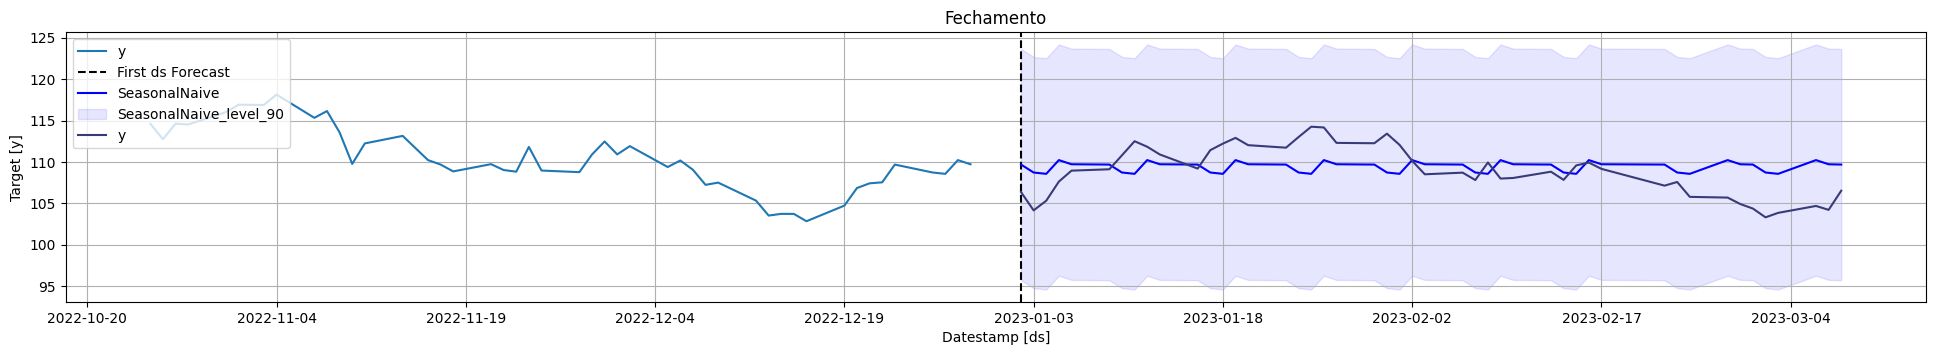

In [914]:
model_s = StatsForecast(models = [SeasonalNaive(season_length = 5)], freq = 'D', n_jobs = -1) #o parâmetro season_length é o padrão que se deseja estabelecer
model_s.fit(treino)
forecast_dfs = model_s.predict(h = h, level = [90])
forecast_dfs.ds = valid.ds.to_list()
forecast_dfs = forecast_dfs.reset_index().merge(valid, on = ['ds', 'unique_id'], how = 'left')
model_s.plot(treino, forecast_dfs, level = [90], engine = 'matplotlib', max_insample_length = 46)

In [915]:
wmape_s = wmape(forecast_dfs['y'].values, forecast_dfs['SeasonalNaive'].values)
print(f'WMAPE: {wmape_s:.2%}')

WMAPE: 2.44%


In [916]:
forecast_dfs.head()

unique_id         ds  SeasonalNaive  SeasonalNaive-lo-90  \
0  Fechamento 2023-01-02     109.697998            95.734352   
1  Fechamento 2023-01-03     108.737999            94.774353   
2  Fechamento 2023-01-04     108.578003            94.614357   
3  Fechamento 2023-01-05     110.237000            96.273354   
4  Fechamento 2023-01-06     109.735001            95.771355   

   SeasonalNaive-hi-90        y  
0           123.661644  106.376  
1           122.701645  104.166  
2           122.541649  105.334  
3           124.200645  107.641  
4           123.698647  108.964

### Modelo baseline com sazonalidade e média móvel

In [917]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage

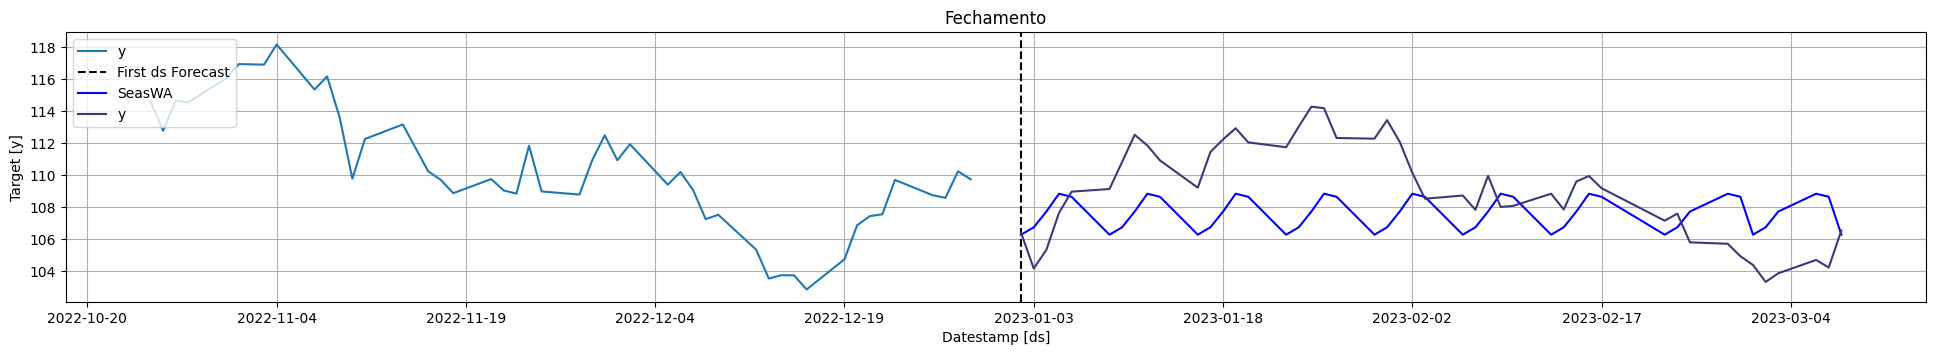

In [918]:
model_sm = StatsForecast(models = [SeasonalWindowAverage(season_length = 5, window_size = 2)], freq = 'D', n_jobs = -1) #o parâmetro window_size é período em que será calculada a média móvel (2 semanas)
model_sm.fit(treino)
forecast_dfsm = model_sm.predict(h = h, level = [90])
forecast_dfsm.ds = valid.ds.to_list()
forecast_dfsm = forecast_dfsm.reset_index().merge(valid, on = ['ds', 'unique_id'], how = 'left')
model_sm.plot(treino, forecast_dfsm, level = [90], engine = 'matplotlib', max_insample_length = 46)

In [919]:
wmape_sm = wmape(forecast_dfsm['y'].values, forecast_dfsm['SeasWA'].values)
print(f'WMAPE: {wmape_sm:.2%}')

WMAPE: 2.63%


In [920]:
forecast_dfsm.head()

unique_id         ds      SeasWA        y
0  Fechamento 2023-01-02  106.277000  106.376
1  Fechamento 2023-01-03  106.738998  104.166
2  Fechamento 2023-01-04  107.721001  105.334
3  Fechamento 2023-01-05  108.834999  107.641
4  Fechamento 2023-01-06  108.643501  108.964

### Modelo ARIMA

In [921]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

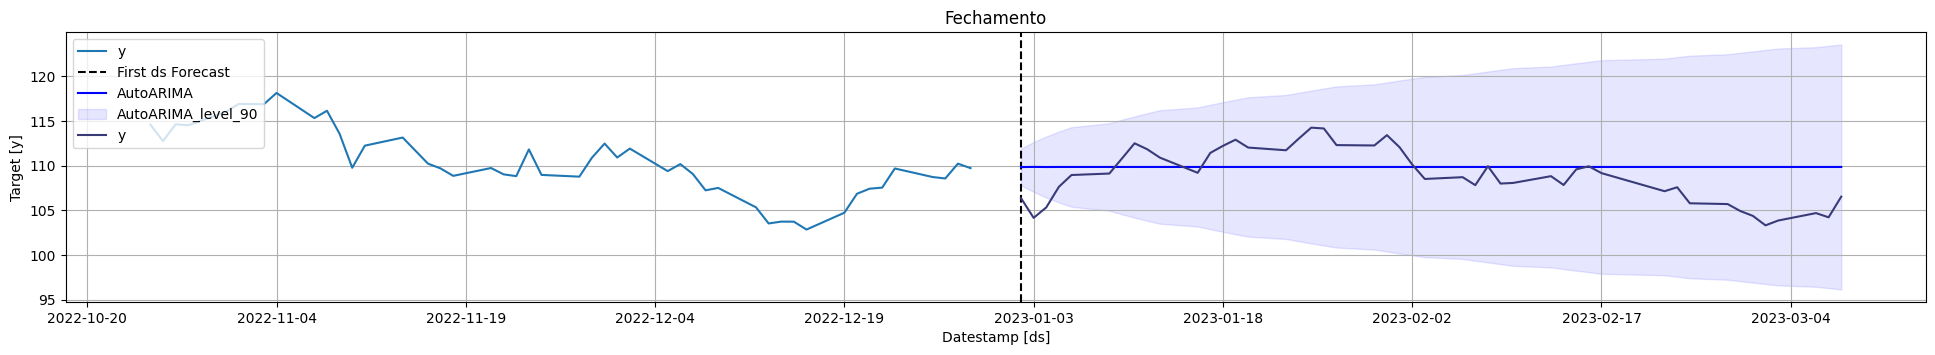

In [922]:
model_a = StatsForecast(models = [AutoARIMA(season_length = 5)], freq = 'D', n_jobs = -1)
model_a.fit(treino)
forecast_dfa = model_a.predict(h = h, level = [90])
forecast_dfa.ds = valid.ds.to_list()
forecast_dfa = forecast_dfa.reset_index().merge(valid, on = ['ds', 'unique_id'], how = 'left')
model_a.plot(treino, forecast_dfa, level = [90], engine = 'matplotlib', max_insample_length = 46)

In [923]:
wmape_a = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
print(f'WMAPE: {wmape_a:.2%}')

WMAPE: 2.42%


In [924]:
forecast_dfa.head()

unique_id         ds   AutoARIMA  AutoARIMA-lo-90  AutoARIMA-hi-90  \
0  Fechamento 2023-01-02  109.854813       107.785172       111.924446   
1  Fechamento 2023-01-03  109.872604       107.085907       112.659309   
2  Fechamento 2023-01-04  109.860443       106.441780       113.279114   
3  Fechamento 2023-01-05  109.866241       105.892731       113.839745   
4  Fechamento 2023-01-06  109.865677       105.408401       114.322960   

         y  
0  106.376  
1  104.166  
2  105.334  
3  107.641  
4  108.964

### Auto ARIMA

In [925]:
from pmdarima.arima import auto_arima

In [926]:
stepwise_model = auto_arima(df.drop('unique_id', axis = 1).set_index('ds', drop = True), start_p = 1, start_q = 1,
                           max_p = 3, max_q = 3, m = 12,
                           start_P = 0, seasonal = True,
                           d = 1, D = 1, trace = True,
                           error_action = 'ignore',  
                           suppress_warnings = True, 
                           stepwise = True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=12.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18360.563, Time=0.36 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=16887.166, Time=1.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=10.49 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=18330.480, Time=0.41 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=16335.132, Time=2.22 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=32.57 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=13.32 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=16358.599, Time=2.85 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=16336.654, Time=4.28 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=16336.433, Time=5.70 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=16335.680, Time=2.94 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=16338.411, Time=10.99 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=16337.129, Time=14.30 sec

Best model:  ARIMA(1,1

In [927]:
treino_autoarima = treino.drop('unique_id', axis = 1).set_index('ds', drop = True)
stepwise_model.fit(treino_autoarima)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [928]:
future_forecast = stepwise_model.predict(n_periods = 46)
valid_autoarima = valid.reset_index(inplace = True, drop = True)
valid_autoarima.drop('unique_id', axis = 1, inplace = True)
valid_autoarima.set_index('ds', inplace = True)
valid_autoarima.head()

AttributeError: 'NoneType' object has no attribute 'drop'

In [ ]:
wmape_a = wmape(valid_autoarima.values, future_forecast.values)
print(f'WMAPE: {wmape_a:.2%}')

WMAPE: 2.55%


In [ ]:
future_forecast = pd.DataFrame(future_forecast.values, index = valid_autoarima.index, columns = ['Prediction'])
valid_autoarima = valid_autoarima.rename(columns = {'y': 'Fechamento'})

fig = px.line(valid, width = 800, height = 600)
fig.add_scatter(x = future_forecast.index, y = future_forecast.Prediction, name = 'Previsão')

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento',
    legend_title = 'Legenda'
)

fig.show()

### Prophet

In [ ]:
from prophet import Prophet

In [935]:
treino_prophet = treino.reset_index(drop = True).drop('unique_id', axis = 1)
valid_prophet = valid
h

46

In [936]:
treino_prophet

ds        y
0    2013-01-02   62.550
1    2013-01-03   63.312
2    2013-01-04   62.523
3    2013-01-07   61.933
4    2013-01-08   61.128
...         ...      ...
2470 2022-12-23  109.698
2471 2022-12-26  108.738
2472 2022-12-27  108.578
2473 2022-12-28  110.237
2474 2022-12-29  109.735

[2475 rows x 2 columns]

In [937]:
m = Prophet()
m.fit(treino_prophet)

16:10:13 - cmdstanpy - INFO - Chain [1] start processing
16:10:14 - cmdstanpy - INFO - Chain [1] done processing


In [938]:
future = m.make_future_dataframe(periods = 46, include_history = False)

In [939]:
forecast_prophet = m.predict(future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds        yhat  yhat_lower  yhat_upper
0 2022-12-30  107.846078  100.934505  114.963009
1 2022-12-31  110.494314  103.260490  117.230645
2 2023-01-01  110.615263  103.137223  117.281770
3 2023-01-02  108.218171  101.481554  115.312753
4 2023-01-03  108.281581  100.910379  114.784081

In [940]:
forecast_prophet[['ds', 'yhat']].head()

ds        yhat
0 2022-12-30  107.846078
1 2022-12-31  110.494314
2 2023-01-01  110.615263
3 2023-01-02  108.218171
4 2023-01-03  108.281581

In [941]:
valid_prophet[['ds', 'y']].head()

ds        y
0 2023-01-02  106.376
1 2023-01-03  104.166
2 2023-01-04  105.334
3 2023-01-05  107.641
4 2023-01-06  108.964

In [942]:
valid_prophet = valid_prophet.sort_values(by = 'ds').drop('unique_id', axis = 1).set_index('ds')
valid_prophet.head()

y
ds                 
2023-01-02  106.376
2023-01-03  104.166
2023-01-04  105.334
2023-01-05  107.641
2023-01-06  108.964

In [943]:
forecast_prophet = forecast_prophet[['ds', 'yhat']].set_index('ds')
forecast_prophet.index = valid_prophet.index
forecast_prophet.head()

yhat
ds                    
2023-01-02  107.846078
2023-01-03  110.494314
2023-01-04  110.615263
2023-01-05  108.218171
2023-01-06  108.281581

In [944]:
wmape_a = wmape(valid_prophet['y'].values, forecast_prophet['yhat'].values)
print(f'WMAPE: {wmape_a:.2%}')

WMAPE: 2.57%


In [950]:
valid_prophet = valid_prophet.rename(columns = {'y': 'Fechamento'})

fig = px.line(valid_prophet, width = 800, height = 600)
fig.add_scatter(x = forecast_prophet.index, y = forecast_prophet.yhat, name = 'Previsão')

fig.update_layout(
    margin = dict(l = 80, r = 20, t = 60, b = 50),
    paper_bgcolor = 'LightSteelBlue',
    title = 'Time Series Suavizado Média Móvel',
    xaxis_title = 'Período',
    yaxis_title = 'Fechamento',
    legend_title = 'Legenda'
)

fig.show()